###Imports and definitions

In [84]:
import numpy as np
import math
import pandas as pd

from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

import torch
from torch import nn as nn, optim as optim, functional as F
from datetime import datetime


In [57]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#4.a

###generating the data

In [58]:
X = [np.array([1,0])]
Y=[]
steps=2000
sig1=0.01
sig2=0.2
e1 =np.random.normal(0, sig1, (2000,2))
e2 =np.random.normal(0, sig2, (2000,2))

A=np.array([[(np.sqrt(99)/10),(-1/10)],[(1/10),((np.sqrt(99)/10))]])
B=np.array([[(np.sqrt(2)/2),(-2/2)],[(np.sqrt(2)/2),((np.sqrt(2)/2))]])
x0 = np.array([1, 0]) + e1[0, :]
y0 = B.dot(x0) + e2[0, :]

length = 2000
train_size = 1000
test_size = 1000

X = [x0]
Y = [y0]

In [59]:
for i in range(steps):
    X_new = np.dot(A,X[i])+e1[i-1, :]
    Y_new = np.dot(B,X_new)+e2[i, :]
    X.append(X_new)
    Y.append(Y_new)


X = pd.DataFrame(X)
y = pd.DataFrame(Y)

In [60]:
X

,0,1
0,1.004967,-0.001383
1,1.016502,0.102727
2,1.006101,0.202480
3,0.987287,0.317306
4,0.948266,0.412102
...,...,...
1996,0.031249,-0.414965
1997,0.055697,-0.414472
1998,0.077110,-0.399314
1999,0.096004,-0.389317


#4.b 

###Using LSTM to predict the next observation

In [61]:
def train_val_test_split(X, y, val_ratio, test_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [62]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2, 0.5)

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

###Setting hyper parameters

In [63]:
input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 64
layer_dim = 3
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
batch_size = 50

In [64]:
train_features = torch.Tensor(X_train_arr)  # torch.Size([800, 2])
train_targets = torch.Tensor(y_train_arr)  # torch.Size([800, 2])
val_features = torch.Tensor(X_val_arr)  # torch.Size([200, 2])
val_targets = torch.Tensor(y_val_arr)  # torch.Size([200, 2])
test_features = torch.Tensor(X_test_arr)  # torch.Size([1000, 2])
test_targets = torch.Tensor(y_test_arr)  # torch.Size([1000, 2])

In [65]:
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

In [66]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

##Building the Model

In [72]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        # h0 = torch(self.layer_dim, x.size(0), self.hidden_dim)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size) so that it can fit into the
        # fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (hidden_dim, output_dim)
        out = self.fc(out)

        return out

In [79]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):  # for single batch
        # Sets model to train mode
        self.model.train()

        # Makes predictions per batch (x is the batch)
        yhat = self.model(x)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        # print("y",y, "Yhat",yhat,"Loss",loss)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=10, n_epochs=50, n_features=2):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        

        for epoch in range(1, n_epochs + 1):

            # for train set:
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            # for val: torch.no_grad() means that we dont want to calculate gradient for the backpropagation- because
            # it's validation/test set and not train set
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch%10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

        # torch.save(self.model.state_dict(), model_path)

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

    def evaluate(self, test_loader, batch_size=1, n_features=2):
        with torch.no_grad():  # torch.no_grad() means that we dont want to calculate gradient for the 
            # backpropagation- because it's validation/test set and not train set 
            predictions = []
            values = []
            test_error = []

            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
                error = self.loss_fn(y_test, yhat).item()
                test_error.append(error)
            mean_error = np.mean(test_error)
            # self.error.append(mean_error)

        return predictions, values, test_error

In [80]:
model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout}

model = LSTMModel(**model_params)

[10/100] Training loss: 0.0395	 Validation loss: 0.0543
[20/100] Training loss: 0.0082	 Validation loss: 0.0054
[30/100] Training loss: 0.0069	 Validation loss: 0.0046
[40/100] Training loss: 0.0058	 Validation loss: 0.0040
[50/100] Training loss: 0.0052	 Validation loss: 0.0040
[60/100] Training loss: 0.0049	 Validation loss: 0.0039
[70/100] Training loss: 0.0048	 Validation loss: 0.0040
[80/100] Training loss: 0.0047	 Validation loss: 0.0040
[90/100] Training loss: 0.0047	 Validation loss: 0.0040
[100/100] Training loss: 0.0046	 Validation loss: 0.0041


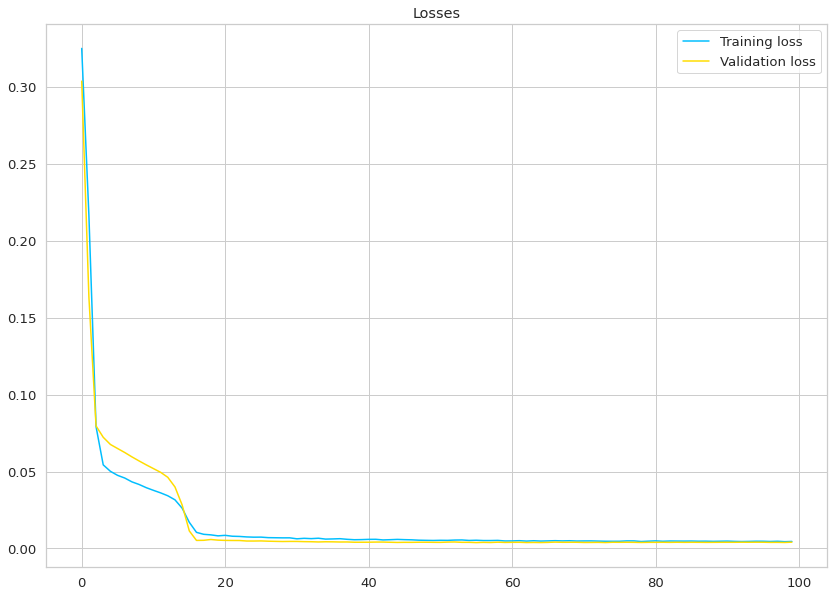

0.00384397172901945

In [81]:
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values, error = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

error = pd.Series(error)
error.abs().mean()

In [85]:
predictions = pd.DataFrame(preds)
predictions.rename(columns={0: 'y1_predicted', 1: 'y2_predicted'}, inplace=True)
values = pd.DataFrame(vals)
values.rename(columns={0: 'y1', 1: 'y2'}, inplace=True)

results = pd.concat([values, predictions], axis=1)

x_test_arr = pd.DataFrame(X_test_arr)
x_test_arr.rename(columns={0: 'X1', 1: 'X2'}, inplace=True)

frames = [x_test_arr, results]
df_result = pd.concat(frames, axis=1)

results

df_result

,X1,X2,y1,y2,y1_predicted,y2_predicted
0,0.974111,0.311662,0.855075,0.587610,0.807624,0.668645
1,0.988680,0.355328,0.742322,0.649253,0.783602,0.696114
2,0.996665,0.402639,0.722853,0.682572,0.754375,0.722456
3,0.999345,0.449842,0.732257,0.789744,0.722938,0.746260
4,0.992738,0.499177,0.688482,0.669263,0.686514,0.767212
...,...,...,...,...,...,...
996,0.523455,0.317661,0.672479,0.428649,0.615494,0.454124
997,0.533441,0.317859,0.701488,0.488685,0.620312,0.459766
998,0.542188,0.323979,0.568983,0.572879,0.620283,0.467871
999,0.549906,0.328016,0.628346,0.399751,0.621210,0.474289


##Metrics

In [86]:
def calculate_metrics(df):
    return {'mae': mean_absolute_error(vals, preds),
            'rmse': mean_squared_error(vals, preds) ** 0.5,
            'r2': r2_score(vals, preds)}


result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 0.04970971, 'r2': 0.8901769732012703, 'rmse': 0.06199978165362157}

#4.c

generating the data

In [87]:
train_features = torch.Tensor(y_train_arr)  # torch.Size([800, 2])
train_targets = torch.Tensor(X_train_arr)  # torch.Size([800, 2])
val_features = torch.Tensor(y_val_arr)  # torch.Size([200, 2])
val_targets = torch.Tensor(X_val_arr)  # torch.Size([200, 2])
test_features = torch.Tensor(y_test_arr)  # torch.Size([1000, 2])
test_targets = torch.Tensor(X_test_arr)  # torch.Size([1000, 2])

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

# DataLoader wraps an iterable around the Dataset to enable easy access to the samples:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout}

model = LSTMModel(**model_params)

[10/100] Training loss: 0.0057	 Validation loss: 0.0052
[20/100] Training loss: 0.0054	 Validation loss: 0.0052
[30/100] Training loss: 0.0052	 Validation loss: 0.0054
[40/100] Training loss: 0.0052	 Validation loss: 0.0052
[50/100] Training loss: 0.0051	 Validation loss: 0.0053
[60/100] Training loss: 0.0052	 Validation loss: 0.0055
[70/100] Training loss: 0.0051	 Validation loss: 0.0053
[80/100] Training loss: 0.0050	 Validation loss: 0.0054
[90/100] Training loss: 0.0050	 Validation loss: 0.0055
[100/100] Training loss: 0.0051	 Validation loss: 0.0054


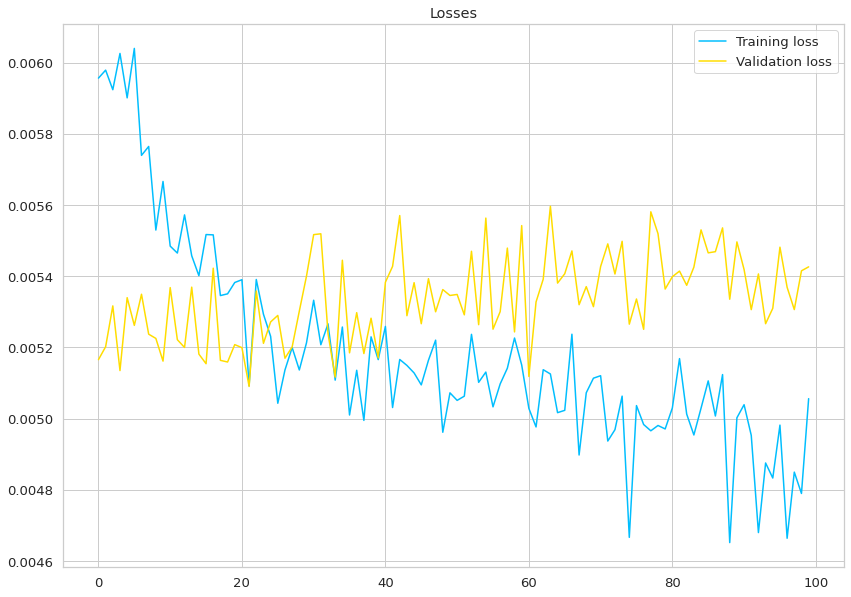

In [89]:
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values, error = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

In [90]:
predictions = pd.DataFrame(preds)
predictions.rename(columns={0: 'X1_predicted', 1: 'X2_predicted'}, inplace=True)
values = pd.DataFrame(vals)
values.rename(columns={0: 'X1', 1: 'X2'}, inplace=True)

results = pd.concat([values, predictions], axis=1)

y_test_arr = pd.DataFrame(y_test_arr)
y_test_arr.rename(columns={0: 'y1', 1: 'y2'}, inplace=True)

frames = [y_test_arr, results]
df_result_x = pd.concat(frames, axis=1)

df_result

df_result_x

,y1,y2,X1,X2,X1_predicted,X2_predicted
0,0.855075,0.587610,0.974111,0.311662,0.860740,0.259300
1,0.742322,0.649253,0.988680,0.355328,0.896195,0.365689
2,0.722853,0.682572,0.996665,0.402639,0.914000,0.410622
3,0.732257,0.789744,0.999345,0.449842,0.938371,0.493333
4,0.688482,0.669263,0.992738,0.499177,0.898274,0.421843
...,...,...,...,...,...,...
996,0.672479,0.428649,0.523455,0.317661,0.586689,0.197711
997,0.701488,0.488685,0.533441,0.317859,0.697057,0.228514
998,0.568983,0.572879,0.542188,0.323979,0.708319,0.436599
999,0.628346,0.399751,0.549906,0.328016,0.502418,0.210926


In [91]:
result_metrics = calculate_metrics(df_result_x)
result_metrics

{'mae': 0.06548453, 'r2': 0.8718628492329408, 'rmse': 0.08167933864874756}